## Section 1: Stock Open Price Prediction

## Section 2: Project Definition

### Goal
Predict the Open Price of singtel stock (Z74.SI) in SGX.

### Dataset

https://sg.finance.yahoo.com/quote/Z74.SI/history?p=Z74.SI

The data is obtained from Yahoo Fiancial. It inlcudes for following infomation.

***Open*** - Open value of the stock   
***High*** - Highest value for the stock on that day   
***Low*** - Lowest value of the stock for the day  
***Close*** - Closing place of the stock on the day   
***Adj Close*** - Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions   
***Volume*** - Volume of stock trade on that day    
***Date*** - Date of the data collected dd/MM/yyyy format   



### Tasks

Tasks to be perform.
 
1. Process the dataset to convert strings into labels.
2. Shuffle and split into train and test sets
3. Train a classification model, using algorithm A, B, C...
4. Compute the metrics for the algorithm.
5. Perform analysis for possible improvements.

### Libraries

Uses package from core python, numpy, pandas, matplotlib , sklearn and keras


***1) Import all the dependencies needed for this project***

In [1]:
from datetime import datetime

## numpy
import numpy as np
from numpy import sqrt
from numpy import concatenate

## pandas
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

## matplotlib
import matplotlib.pyplot as plt

## sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## keras
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

## misc
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline

## Section 3: Data Engineering


***Import the data set from csv and preview the data info***

In [2]:
data = pd.read_csv("Z74.SI.5YR.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1253 non-null   object 
 1   Open       1253 non-null   float64
 2   High       1253 non-null   float64
 3   Low        1253 non-null   float64
 4   Close      1253 non-null   float64
 5   Adj Close  1253 non-null   float64
 6   Volume     1253 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.6+ KB


In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,28/8/2014,3.91,3.94,3.90,3.91,3.013353,11606000
1,29/8/2014,3.89,3.89,3.87,3.89,2.997940,11875000
2,1/9/2014,3.89,3.90,3.86,3.87,2.982526,6806000
3,2/9/2014,3.89,3.94,3.88,3.94,3.036473,10578000
4,3/9/2014,3.95,3.97,3.92,3.93,3.028767,10645000


### Data Cleasing

In [5]:
empty = data[data.isna().any(axis=1)].copy()

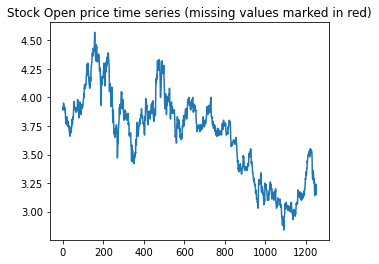

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(data['Open'])

# mark the rows that are NaN
ax.scatter(empty.index, empty['Open'], marker='x', color='red')

ax.set_title('Stock Open price time series (missing values marked in red)')

plt.show()

#Can redo for all columns

In [7]:
## Check any null value
data.isnull().values.any()

## Replace missing value with median value. 
## For this dataset they are no missing value, so i will be not run the code

## The code is to illustrate what i will do if there are missing value.

# median = data['Close'].median()
# data['NUM_BEDROOMS'].fillna(median, inplace=True)

False

### Data Exploration

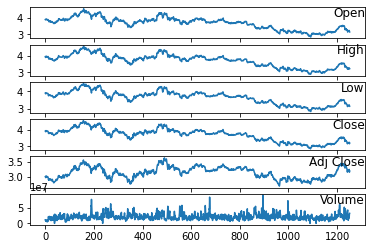

In [8]:
values = data.values
# specify columns to plot
groups = [ 1, 2, 3, 4, 5 , 6 ]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

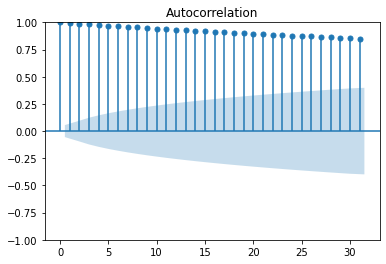

In [9]:
plot_acf(data['Open'])
plt.show()

Open price is correlated to > 30 lags (Day)

### Imbalance / Data Sampling

The target of this project is not a classification prediction. Therefore does not check for inbalance classes.   
There is also not categorical data in the dataset.

###  Data Encoding

In [10]:
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,28/8/2014,3.91,3.94,3.90,3.91,3.013353,11606000
1,29/8/2014,3.89,3.89,3.87,3.89,2.997940,11875000


The data set consist of a date column and the rest of the feature are in numerical form.  
No categories transformation/encoding is not needed for this dataset.

## Section 4: Feature Engineering

###  Pearson's correlation coefficient 

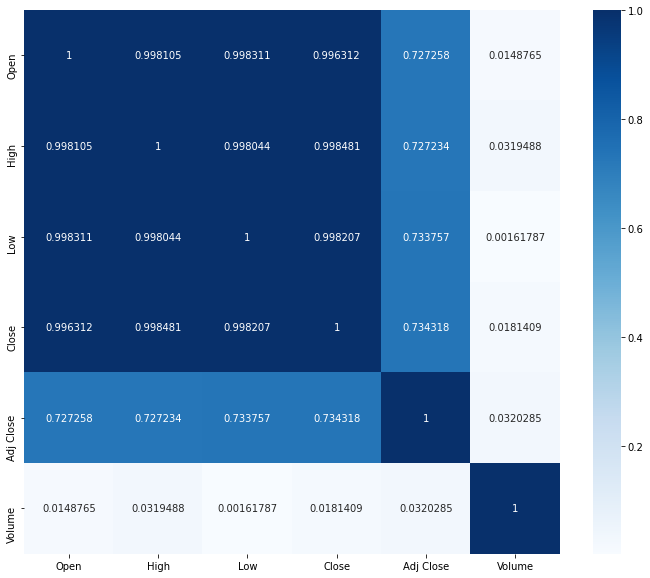

In [11]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True,cmap='Blues', fmt='g')
plt.show()

In [12]:

#Correlation with output variable
cor_target = abs(cor["Open"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.5]
print(relevant_features)


Open         1.000000
High         0.998105
Low          0.998311
Close        0.996312
Adj Close    0.727258
Name: Open, dtype: float64


We use > 0.8 to filter those highly correlated attribute against Open price.   
***High, Low and Close*** are the 3 attributes which is highly correlated to ***Open price***.

So we can choose this 3 columns as the feature and Open Price.


## Section 5: Model Engineering

### Models to use

Long Short-Term Memory (LSTM) will be used.  
The networks are designed for sequence prediction problems.   

Many-to-One Model is used. A many-to-one model produces one output value after receiving multiple input values.   
Our model will have 4 input (Open, High, Low and Close) and 1 output (Open price).

### Hyperparameters

- choosing the right amount of nodes and layers

### Data for training, test and validation

A simple strategy is used for diving train and test set.  
Data is divide into 50% train and 50% test

## Section 6: Evalution metric

## Section 7: Training model without time lags (timestep = 1)

### Define function(s)
Define the function series_to_supervised, This is from referenced from Jason Brownlee which i find it useful.

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Select columns for training the model

In [14]:
## Display the available columns names
print(data.columns)

## from the available column, choose which column to use base on the feature selection
## The target attribute has to be the first column
selected_columns = ['Open', 'High', 'Low', 'Close','Adj Close']

## make a copy of the selected data
selected_data = data[selected_columns].copy()

print(selected_data.head())                     

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
   Open  High   Low  Close  Adj Close
0  3.91  3.94  3.90   3.91   3.013353
1  3.89  3.89  3.87   3.89   2.997940
2  3.89  3.90  3.86   3.87   2.982526
3  3.89  3.94  3.88   3.94   3.036473
4  3.95  3.97  3.92   3.93   3.028767


### Reframe the data

In [15]:
values = selected_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
# time step here is 1
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
rows, reframed_columns = reframed.shape

## this part is to drop the last 4 column from the reframed data
column = selected_data.shape[1]
col = []
for x in range(reframed_columns - column + 1, reframed_columns):
    col.append(x)
    
reframed.drop(reframed.columns[col], axis=1, inplace=True)
print(reframed.head())

## This code is referenced from Jason Brownlee tutorial with some modification
## var1 = Open, var2 = High , var3 = Low , var4 = Close  var5=Adj Close

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.618497   0.625000   0.652439   0.628742   0.333396  0.606936
2   0.606936   0.595238   0.634146   0.616766   0.316586  0.606936
3   0.606936   0.601190   0.628049   0.604790   0.299776  0.606936
4   0.606936   0.625000   0.640244   0.646707   0.358610  0.641618
5   0.641618   0.642857   0.664634   0.640718   0.350206  0.635838


### Split into train and test sets

In [16]:
# split into train and test sets
values = reframed.values

## Our timestep is in days. since 50% is used for training
n_train_days = selected_data.shape[0]//2
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(626, 1, 5) (626,) (626, 1, 5) (626,)


### Built the model

In [17]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

### Train the model

In [18]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
20/20 - 0s - loss: 0.4593 - val_loss: 0.1363
Epoch 2/50
20/20 - 0s - loss: 0.2156 - val_loss: 0.0631
Epoch 3/50
20/20 - 0s - loss: 0.0585 - val_loss: 0.0995
Epoch 4/50
20/20 - 0s - loss: 0.0292 - val_loss: 0.0769
Epoch 5/50
20/20 - 0s - loss: 0.0392 - val_loss: 0.0820
Epoch 6/50
20/20 - 0s - loss: 0.0328 - val_loss: 0.0729
Epoch 7/50
20/20 - 0s - loss: 0.0373 - val_loss: 0.0774
Epoch 8/50
20/20 - 0s - loss: 0.0309 - val_loss: 0.0674
Epoch 9/50
20/20 - 0s - loss: 0.0361 - val_loss: 0.0724
Epoch 10/50
20/20 - 0s - loss: 0.0294 - val_loss: 0.0621
Epoch 11/50
20/20 - 0s - loss: 0.0345 - val_loss: 0.0663
Epoch 12/50
20/20 - 0s - loss: 0.0285 - val_loss: 0.0576
Epoch 13/50
20/20 - 0s - loss: 0.0325 - val_loss: 0.0599
Epoch 14/50
20/20 - 0s - loss: 0.0271 - val_loss: 0.0517
Epoch 15/50
20/20 - 0s - loss: 0.0316 - val_loss: 0.0553
Epoch 16/50
20/20 - 0s - loss: 0.0256 - val_loss: 0.0470
Epoch 17/50
20/20 - 0s - loss: 0.0297 - val_loss: 0.0495
Epoch 18/50
20/20 - 0s - loss: 0.0246 - 

### Plot the history graph

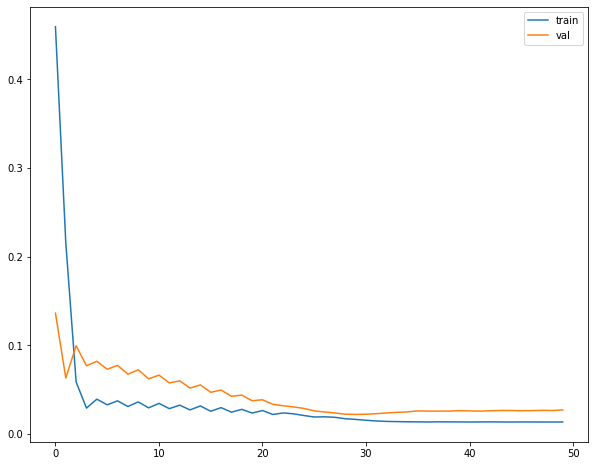

In [19]:
# plot history
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.legend()
plt.show()

### Evaluation of model with RMSE

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse_1 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Evaluation result for 1 time step (measure in RMSE): %.3f' % rmse_1)

Evaluation result for 1 time step (measure in RMSE): 0.058


## Section 8: Training model  with timestep = 3

### Reframe the data to for 3 timestep

In [21]:

# specify the number of lag days since our time step is days
n_days = 3
n_features =  len(selected_columns) 
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)

#rows, reframed_columns = reframed.shape
#print(reframed_columns)

# split into train and test sets
values = reframed.values

# use 50 % of data set
n_train_days = selected_data.shape[0]//2
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [22]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.618497,0.625000,0.652439,0.628742,0.333396,0.606936,0.595238,0.634146,0.616766,0.316586,0.606936,0.601190,0.628049,0.604790,0.299776,0.606936,0.625000,0.640244,0.646707,0.358610
4,0.606936,0.595238,0.634146,0.616766,0.316586,0.606936,0.601190,0.628049,0.604790,0.299776,0.606936,0.625000,0.640244,0.646707,0.358610,0.641618,0.642857,0.664634,0.640718,0.350206
5,0.606936,0.601190,0.628049,0.604790,0.299776,0.606936,0.625000,0.640244,0.646707,0.358610,0.641618,0.642857,0.664634,0.640718,0.350206,0.635838,0.630952,0.658537,0.640718,0.350206
6,0.606936,0.625000,0.640244,0.646707,0.358610,0.641618,0.642857,0.664634,0.640718,0.350206,0.635838,0.630952,0.658537,0.640718,0.350206,0.630058,0.625000,0.646342,0.628742,0.333396
7,0.641618,0.642857,0.664634,0.640718,0.350206,0.635838,0.630952,0.658537,0.640718,0.350206,0.630058,0.625000,0.646342,0.628742,0.333396,0.618497,0.613095,0.646342,0.634730,0.341801


In [23]:

# split into input and outputs
n_obs = n_days * n_features
print(n_obs)
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

15
(626, 15) 626 (626,)


In [24]:

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))


## Built the model

In [25]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


## Train the model

In [26]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
20/20 - 0s - loss: 0.4101 - val_loss: 0.0811
Epoch 2/50
20/20 - 0s - loss: 0.0627 - val_loss: 0.0502
Epoch 3/50
20/20 - 0s - loss: 0.0576 - val_loss: 0.0522
Epoch 4/50
20/20 - 0s - loss: 0.0613 - val_loss: 0.0605
Epoch 5/50
20/20 - 0s - loss: 0.0421 - val_loss: 0.0456
Epoch 6/50
20/20 - 0s - loss: 0.0452 - val_loss: 0.0413
Epoch 7/50
20/20 - 0s - loss: 0.0453 - val_loss: 0.0387
Epoch 8/50
20/20 - 0s - loss: 0.0415 - val_loss: 0.0347
Epoch 9/50
20/20 - 0s - loss: 0.0412 - val_loss: 0.0318
Epoch 10/50
20/20 - 0s - loss: 0.0388 - val_loss: 0.0292
Epoch 11/50
20/20 - 0s - loss: 0.0372 - val_loss: 0.0270
Epoch 12/50
20/20 - 0s - loss: 0.0363 - val_loss: 0.0252
Epoch 13/50
20/20 - 0s - loss: 0.0331 - val_loss: 0.0239
Epoch 14/50
20/20 - 0s - loss: 0.0291 - val_loss: 0.0231
Epoch 15/50
20/20 - 0s - loss: 0.0258 - val_loss: 0.0235
Epoch 16/50
20/20 - 0s - loss: 0.0236 - val_loss: 0.0277
Epoch 17/50
20/20 - 0s - loss: 0.0223 - val_loss: 0.0321
Epoch 18/50
20/20 - 0s - loss: 0.0210 - 

## Plot history Graph

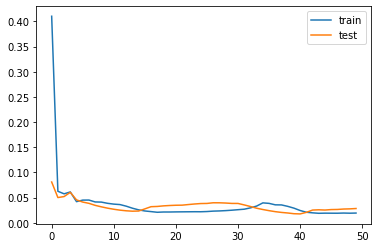

In [27]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluation of model with RMSE

In [28]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse_n = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Evaluation result for %s time-step (measure in RMSE): %.3f' % (n_days , rmse_n))

Evaluation result for 3 time-step (measure in RMSE): 0.059


## Section 9: Observations and analysis

In [29]:
print('Evaluation result for 1 time step (measure in RMSE): %.3f' % rmse_1)

print('Evaluation result for %s time-step (measure in RMSE): %.3f' % (n_days , rmse_n))


Evaluation result for 1 time step (measure in RMSE): 0.058
Evaluation result for 3 time-step (measure in RMSE): 0.059


Training model using LSTM achieved a good accuracy

Further improvement can be obtained by using > 1 timestep.